In [7]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import networkx as nx


from netgraph import Graph, InteractiveGraph

from networkx.algorithms.community import girvan_newman, modularity_max, louvain_communities

from visu_utils import *

# white grid
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2


PREFIX = "mteb_ds"
df = pd.read_csv('exported_data/normalized_13.df')


df = text_embeddings_metadata_results_preprocessing(df, models=MODELS_MAIN_EXPES)
METRIC = "I(X_1->X_2)/d_2"
table = make_table_pivot(METRIC, df)
info = table.median(axis=0).rank(ascending=False)
info.name = METRIC

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:

classifcation_df = pd.read_csv('exported_data/classification_many_3_avg.csv')

classifcation_df['model'] = classifcation_df['model'].apply(lambda x: eval(x)[0])



In [9]:
classifcation_df['Classification 2'] = classifcation_df.groupby(['dataset'])['success'].rank(ascending=False)
classification_df_results = classifcation_df.groupby('model')[['Classification 2', 'success']].mean().sort_values('Classification 2')


In [10]:

METRICS = ['Average (56 datasets)', 'Classification Average (12 datasets)', 'Clustering Average (11 datasets)', 'Retrieval Average (15 datasets)', 'STS Average (10 datasets)', 'Reranking Average (4 datasets)']

mteb = pd.read_csv('exported_data/df_mteb_avg.csv')


import re

def extract_url_from_html_link(html):
    return re.findall(r'href=[\'"]?([^\'" >]+)', html)[0]

mteb['model'] = mteb['Model'].apply(extract_url_from_html_link).apply(lambda x: "/".join(x.split('/')[-2:]))

# replace all METRICS by their rank
for metric in METRICS:
    mteb[metric] = mteb[metric].rank(ascending=False)


In [11]:
avg_results = mteb[['model'] + METRICS].merge(classification_df_results, left_on='model', right_index=True).sort_values('Classification 2')
# add info
avg_results = avg_results.merge(info, left_on='model', right_index=True)

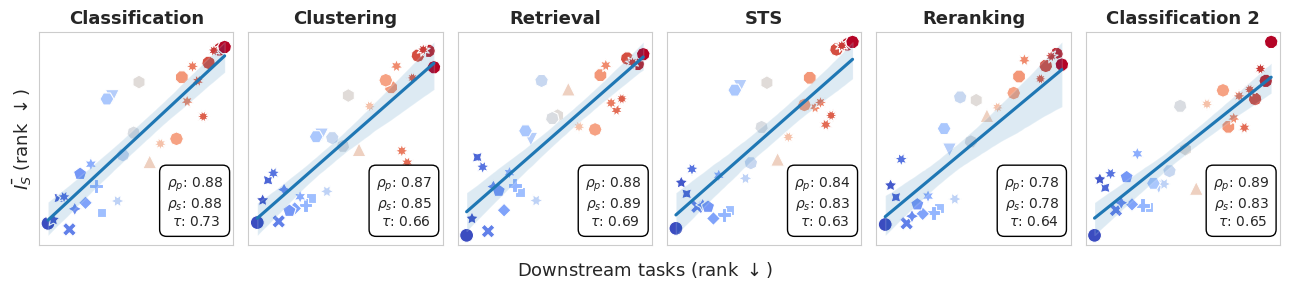

In [14]:

mosaic_map = [
    ['B', 'C', 'D', 'E', 'F', 'A']
]

mosaic_to_task_map = {
    'B': 'Classification Average (12 datasets)',
    'C': 'Clustering Average (11 datasets)',
    'D': 'Retrieval Average (15 datasets)',
    'E': 'STS Average (10 datasets)',
    'F': 'Reranking Average (4 datasets)',
    'A': 'Classification 2',
    
}

mosaic_map = np.array(mosaic_map)
mosaic_map = np.vectorize(lambda x: mosaic_to_task_map[x])(mosaic_map)

MODEL_TO_ANNOATE = set(["UAE-Large-V1", "allenai-specter", "e5-small",  "udever-bloom-560m",])

fig, ax = plt.subplot_mosaic(mosaic_map, figsize=(13, 3))

s = 100

for i, metric in enumerate(list(mosaic_to_task_map.values())):
    ax[metric] = sns.scatterplot(data=avg_results, x=METRIC, y=metric, ax=ax[metric], legend=False, hue = METRIC, style='model', s=s, palette="coolwarm")
    ax[metric] = sns.regplot(data=avg_results, x=METRIC, y=metric, ax=ax[metric], scatter=False)

    # annotate correllation
    spearmann = avg_results[[METRIC, metric]].corr('spearman').loc[[METRIC, metric]].iloc[0, 1]
    pearson = avg_results[[METRIC, metric]].corr('pearson').loc[[METRIC, metric]].iloc[0, 1]
    kendall = avg_results[[METRIC, metric]].corr('kendall').loc[[METRIC, metric]].iloc[0, 1]
    

    ax[metric].annotate(f"$\\rho_p$: {pearson:.2f}\n$\\rho_s$: {spearmann:.2f}\n $\\tau$: {kendall:.2f}", (0.80, 0.2), xycoords='axes fraction', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=10)

    # make regex to remove (.*) 
    
    regex = re.compile(r"\(.*\)")
    text = re.sub(regex, "", metric).replace('Average', '').strip()
    
    ax[metric].set_title(text, fontsize=13, fontweight='bold')
    if i == 0:
        ax[metric].set_ylabel('$\\bar{I_{S}}$ (rank $\\downarrow$)', fontsize=13)
    else:
        ax[metric].set_ylabel('')
    ax[metric].set_xlabel('')
    
    # remove xticks and yticks
    ax[metric].set_xticks([])
    ax[metric].set_yticks([])
    
# add fig title
fig.suptitle(f"Downstream tasks (rank $\\downarrow$)", fontsize=13, y=0.0)
    


fig.tight_layout()

path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/{PREFIX}_scatterplot_mtebs_horizontal_{sanitize_metric_name(METRIC)}.pdf")
path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(path, bbox_inches='tight')
